In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import hex2color

from ChemTopicModel import chemTopicModel, utilsEvaluation, drawTopicModel

import sklearn
from rdkit import rdBase
import matplotlib as mpl
import seaborn as sns
print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
print('Seaborn version',sns.__version__)

RDKit version:  2018.09.2
Pandas version: 0.24.1
Scikit-Learn version: 0.20.2
Numpy version: 1.16.2
MatplotLib version: 3.0.2
Seaborn version 0.9.0


In [2]:
%matplotlib inline

### Load and prepare the ChEMBL23 molecule data

In [3]:
data = pd.read_csv('../chembl23_mols.csv')

In [4]:
data.columns

Index(['prepSmiles', 'canonical_smiles', 'docid', 'molregno'], dtype='object')

In [5]:
data.shape

(1647380, 4)

Filter out screening sets and compound collections

In [6]:
data_filtered = data.groupby("docid").filter(lambda x: len(x) <= 50)

In [7]:
data_filtered.shape

(878400, 4)

Read ChEMBL 23 document data (title and abstracts)

In [8]:
doc_table = pd.read_csv('../docTable_chembl23_new.csv')

In [9]:
filter_docs = doc_table[~doc_table['abstract'].isnull()]

In [10]:
filter_docs.columns

Index(['doc_id', 'pubmed_id', 'title', 'abstract'], dtype='object')

Sample the data to get randomly 100K molecules

In [11]:
data_sample = data_filtered.sample(n=100000, random_state=42)

In [12]:
data_sample.reset_index(drop=True, inplace=True)

In [13]:
#get titles and abstracts for all molecules
abstract=[]
titles=[]
for d in data_sample['docid']:
    dids = list(map(int, d[1:-1].split(',')))
    tmp=''
    tmp2=''
    for did in dids:
        t = filter_docs[filter_docs['doc_id'] == did]['abstract']
        t2 = filter_docs[filter_docs['doc_id'] == did]['title']
#         print(t.isnull())
        if t.isnull().any():
            continue
        if t.values.shape[0] > 0: 
            tmp+=' '+t.values[0]
        if t2.values.shape[0] > 0: 
            tmp2+=' '+t2.values[0]           
    abstract.append(tmp)
    titles.append(tmp2)

In [14]:
len(abstract),len(titles)

(100000, 100000)

In [15]:
#add title and abstract to the molecule table as a column
data_sample['title_abstract']=[x+' '+y for x,y in list(zip(abstract,titles))]

Featurize/tokenize the text data using common natural language processing tools

In [16]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [17]:
tf_vectorizer = TfidfVectorizer(max_df=0.2, min_df=10, max_features=10000, stop_words='english',ngram_range=(2,5), 
                                token_pattern='[A-Za-z]{3,}')
tf = tf_vectorizer.fit_transform(data_sample['title_abstract'])

In [18]:
tf_vectorizer.get_feature_names()[:10]

['abilities inhibit',
 'ability bind',
 'ability block',
 'ability compounds',
 'ability displace',
 'ability induce',
 'ability inhibit',
 'ability predict',
 'abl kinase',
 'able inhibit']

### Build the chemical topic model

Create chemical fragments as usual

In [19]:
chemblTopicModel=chemTopicModel.ChemTopicModel(sizeSampleDataSet=0.25, fragmentMethod='Morgan', rareThres=0.001, 
                                               commonThres=0.1, randomState=23, chunksize=5200, n_jobs=10)

In [20]:
chemblTopicModel.loadData(data_sample)

In [21]:
import time

In [22]:
stime = time.time()
chemblTopicModel.generateFragments()
print("Time:", time.time()-stime)

Time: 233.392085313797


In [23]:
chemblTopicModel.fragM.shape

(100000, 2731)

Combine fragments and text features for input into the topic model

In [24]:
tf.toarray().shape

(100000, 10000)

In [25]:
newFrags = np.concatenate((chemblTopicModel.fragM, tf.toarray()),axis=1)

In [26]:
newFrags.shape

(100000, 12731)

In [27]:
chemblTopicModel.fragM = newFrags

In [28]:
chemblTopicModel.vocabulary = chemblTopicModel.vocabulary+tf_vectorizer.get_feature_names()

Set the number of topics (here 100) and build the model

In [29]:
stime = time.time()
chemblTopicModel.buildTopicModel(100)
print("Time:", time.time()-stime)

Time: 473.05950236320496


Store/reload the model using pickle

In [30]:
import pickle

In [31]:
# with open('TM_chembl23_100Krandom_withText.pkl','wb') as of:
#     pickle.dump(chemblTopicModel, of, protocol=4)

In [32]:
with open('../TM_chembl23_100Krandom_withText.pkl','rb') as of:
    chemblTopicModel = pickle.load(of)

### Calculate the different metrics to explore the topic model in more detail

In [33]:
from collections import Counter

In [34]:
numTopics, numDocs = chemblTopicModel.getTopicFragmentProbabilities().shape

In [35]:
numTopicsMol=[]
for i in range(numDocs):
    numTopicsMol.append(len(Counter(chemblTopicModel.documentTopicProbabilities[i]))-1)

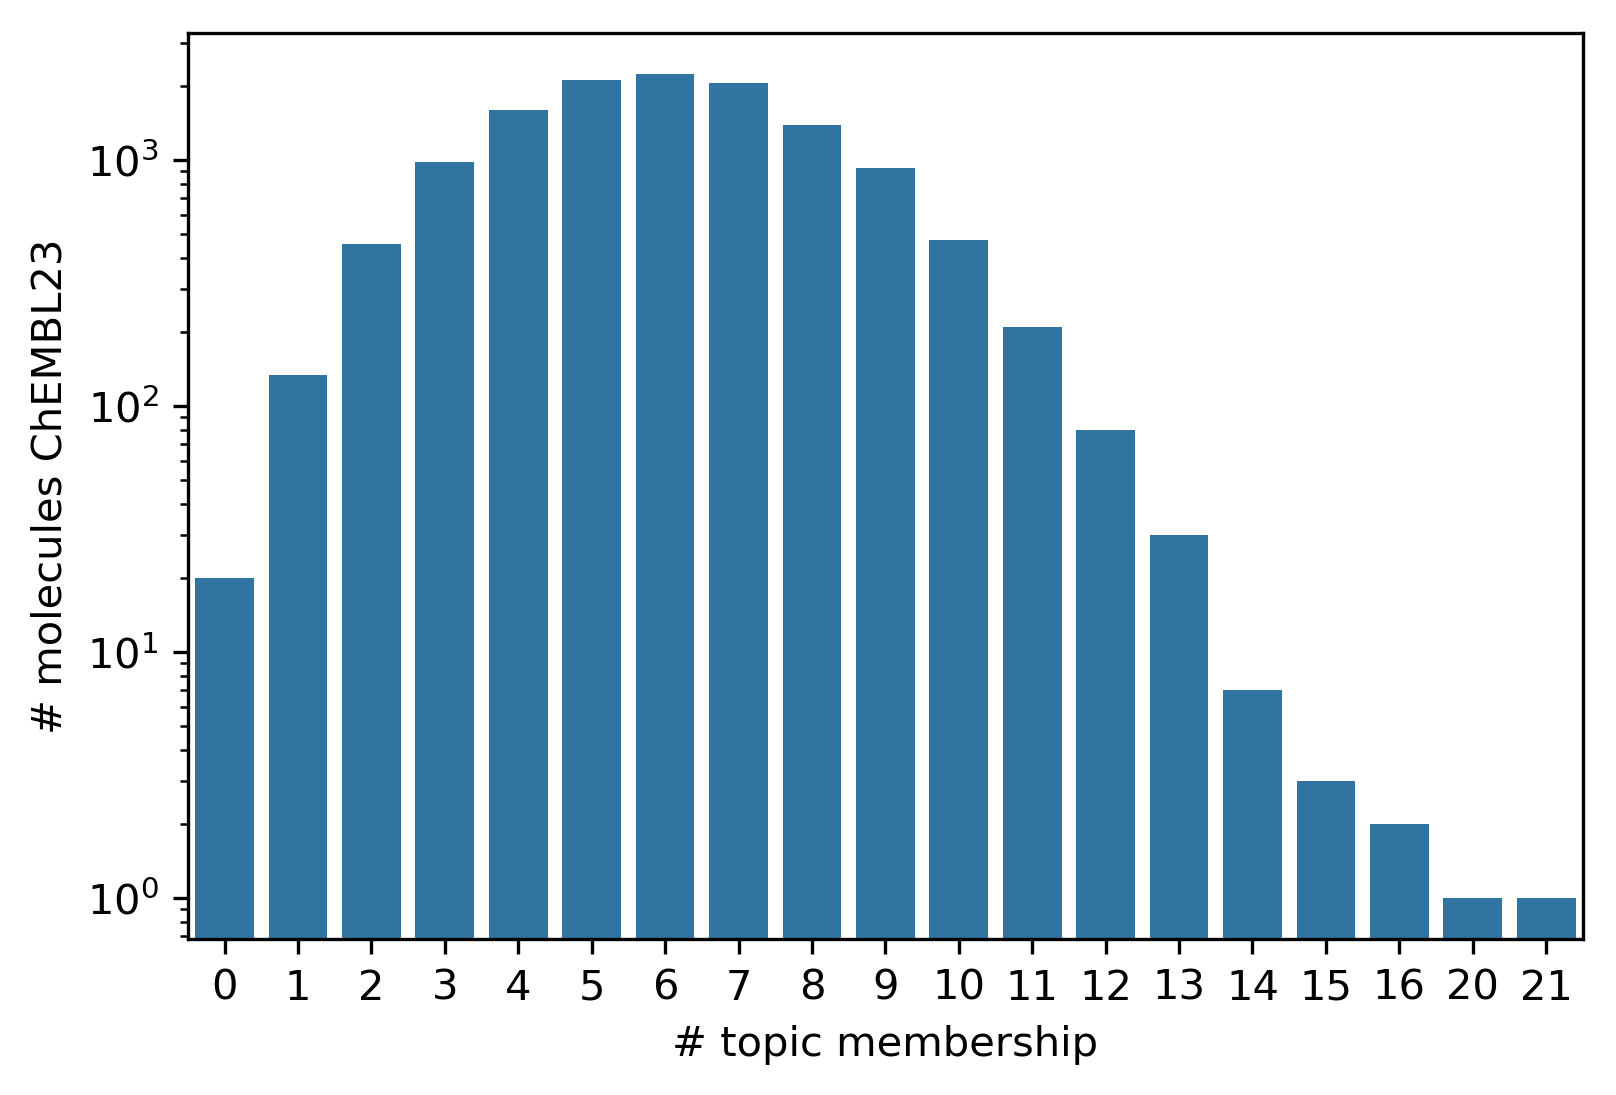

In [36]:
fig, ax = plt.subplots(1, dpi=300,)
sns.countplot(numTopicsMol, color=sns.color_palette()[0], ax=ax)
ax.set_yscale('log')
ax.set_ylabel('# molecules ChEMBL23')
ax.set_xlabel('# topic membership');
# fig.savefig('TopicMembershipChEMBL23.png', dpi=300, bbox_inches='tight')

In [37]:
from ChemTopicModel import utilsChemTM

In [38]:
ranking_result = utilsChemTM.rankInterestingTopics(chemblTopicModel, topXfrags=5)#, minMaxProb=0.15)

In [39]:
ranking_result = ranking_result.sort_values(['fraction high prob. mols'], ascending=False).reset_index(drop=True)

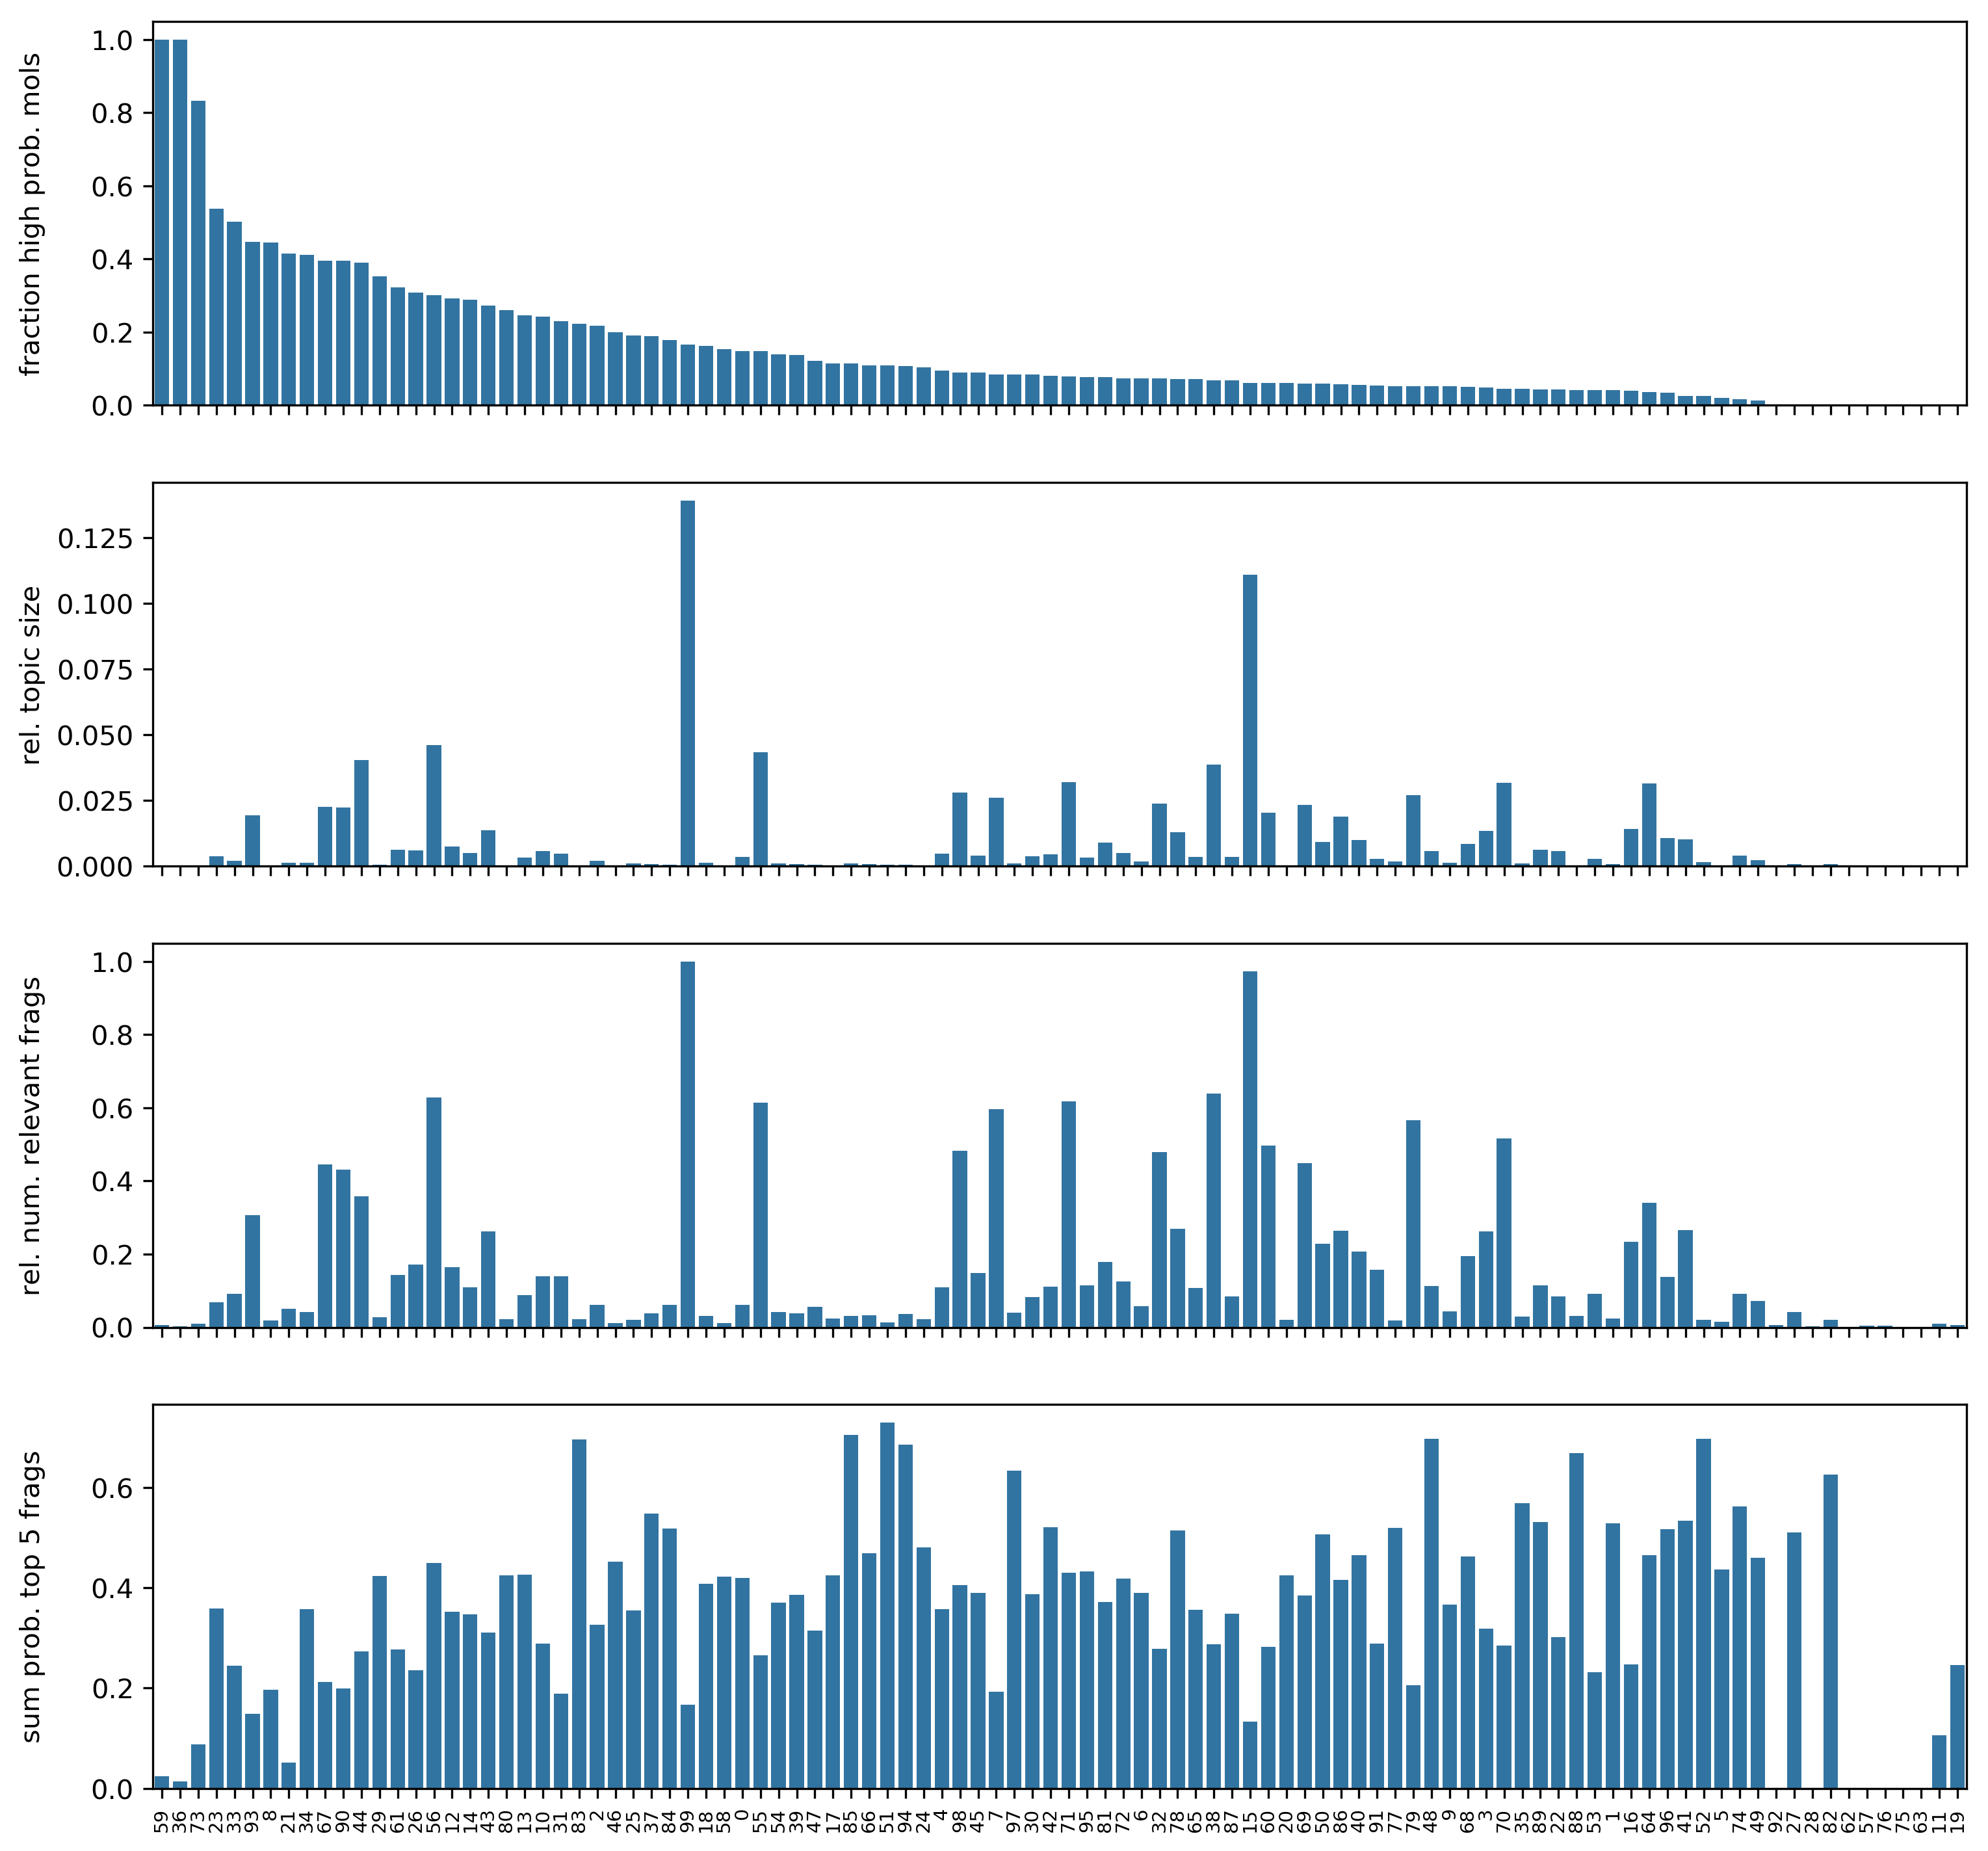

In [40]:
fig,ax=plt.subplots(4,1, figsize=(12,12),dpi=300)
sns.barplot(x=list(range(100)),y=ranking_result['fraction high prob. mols'],color=sns.color_palette()[0], ax=ax[0])
sns.barplot(x=list(range(100)),y=ranking_result['rel. topic size'],color=sns.color_palette()[0], ax=ax[1])
sns.barplot(x=list(range(100)),y=ranking_result['rel. num. relevant frags'],color=sns.color_palette()[0], ax=ax[2])
sns.barplot(x=list(range(100)),y=ranking_result['sum prob. top 5 frags'],color=sns.color_palette()[0], ax=ax[3])
plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)
plt.setp(ax[2].get_xticklabels(), visible=False)

_=ax[3].set_xticklabels(ranking_result['Topic Idx'],rotation=90,fontsize=7,verticalalignment='top')
fig.align_ylabels(ax)
# fig.savefig('TopicRankingChEMBL23.png', dpi=300, bbox_inches='tight')

In [41]:
ranking_result[:8]

,Topic Idx,fraction high prob. mols,abs. topic size,rel. topic size,rel. num. relevant frags,sum prob. top 5 frags
0,59,1.000000,1.0,0.00001,0.005459,0.023832
1,36,1.000000,2.0,0.00002,0.002547,0.013700
2,73,0.833333,6.0,0.00006,0.010189,0.087067
3,23,0.537433,374.0,0.00374,0.068777,0.358753
4,33,0.502370,211.0,0.00211,0.091339,0.244549
5,93,0.447095,1928.0,0.01928,0.306769,0.148668
6,8,0.444444,9.0,0.00009,0.018923,0.197092
7,21,0.414815,135.0,0.00135,0.051310,0.051827


In [42]:
ranking_result[ranking_result['abs. topic size'] != 0].describe()

,Topic Idx,fraction high prob. mols,abs. topic size,rel. topic size,rel. num. relevant frags,sum prob. top 5 frags
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,48.354839,0.167326,1075.268817,0.010753,0.175717,0.384020
std,29.338224,0.192012,2042.919044,0.020429,0.213035,0.158166
min,0.000000,0.000000,1.000000,0.000010,0.002547,0.013700
25%,23.000000,0.052399,95.000000,0.000950,0.030932,0.281548
50%,47.000000,0.084259,356.000000,0.003560,0.091339,0.387497
75%,73.000000,0.222222,1066.000000,0.010660,0.232897,0.468330
max,99.000000,1.000000,13910.000000,0.139100,1.000000,0.729316


In [43]:
def getTopWordsTopic(TM, topicIdx, n_top_words=10):
    probsTidx = TM.getTopicFragmentProbabilities()[topicIdx,:]
    maxNumFrags = len(Counter(probsTidx.astype('float16')))-1
    idssorted=probsTidx.argsort()[::-1][:maxNumFrags]
    result=[]
    countWrds=0
    for i in idssorted[:maxNumFrags]:
        if countWrds < n_top_words:
            if type(TM.vocabulary[i]) == int:
                pass
            else:
#                 print(i)
                result.append(TM.vocabulary[i])
                countWrds+=1
        else:
            break
    return result

Have a detailed view into some of the topics, molecules are shown with ChEMBL paper ID and molregno

In [44]:
idx=23
drawTopicModel.drawFragmentsbyTopic(chemblTopicModel, idx, n_top_frags=8, numRowsShown=2.5,numColumns=8)
print(getTopWordsTopic(chemblTopicModel, idx, n_top_words=10))
drawTopicModel.drawMolsByTopic(chemblTopicModel, idx, idsLabelToShow=[1,2], baseRad=0.9, color=(0.6,0.8,0.9), maxMols=4,
                               topicProbThreshold=0.5, maxTopicProb=0.5)

['cancer cell', 'drug resistant', 'colon cancer', 'cell lines', 'analogues improved', 'similar potency', 'synthesis antifungal activity', 'second generation', 'cancer cell lines', 'activity drug resistant']


[50889] | 624919 | (p=0.98) | (pmax(23)=0.98),[1428] | 150664 | (p=0.97) | (pmax(23)=0.97),[1428] | 150197 | (p=0.97) | (pmax(23)=0.97),[870] | 84000 | (p=0.97) | (pmax(23)=0.97)


In [45]:
idx=18
drawTopicModel.drawFragmentsbyTopic(chemblTopicModel, idx, n_top_frags=8, numRowsShown=2.5,numColumns=8)
print(getTopWordsTopic(chemblTopicModel, idx, n_top_words=10))
drawTopicModel.drawMolsByTopic(chemblTopicModel, idx, idsLabelToShow=[1,2], baseRad=0.9, color=(0.6,0.8,0.9), maxMols=4,
                               topicProbThreshold=0.5, maxTopicProb=0.5)

p(k=18)=0.17,p(k=18)=0.11,p(k=18)=0.06,p(k=18)=0.04,p(k=18)=0.03,p(k=18)=0.03,p(k=18)=0.03,p(k=18)=0.03


['beta lactam', 'beta lactamase', 'lactam antibiotics', 'beta lactam antibiotics', 'antibacterial activity', 'gram negative', 'activity beta', 'methoxy group', 'discover novel', 'lactam ring']


[962] | 192778 | (p=0.90) | (pmax(18)=0.90),[962] | 192779 | (p=0.89) | (pmax(18)=0.89),[1557] | 265786 | (p=0.86) | (pmax(18)=0.86),[83491] | 1751302 | (p=0.79) | (pmax(18)=0.79)


In [46]:
idx=2
drawTopicModel.drawFragmentsbyTopic(chemblTopicModel, idx, n_top_frags=8, numRowsShown=2.5,numColumns=8)
print(getTopWordsTopic(chemblTopicModel, idx, n_top_words=10))
drawTopicModel.drawMolsByTopic(chemblTopicModel, idx, idsLabelToShow=[1,2], baseRad=0.9, color=(0.6,0.8,0.9), maxMols=4,
                               topicProbThreshold=0.5, maxTopicProb=0.5)

['dipeptidyl peptidase', 'hepatitis virus', 'dpp inhibitors', 'peptidase inhibitors', 'dipeptidyl peptidase inhibitors', 'dipeptidyl peptidase dpp', 'peptidase dpp', 'hepatitis virus hcv', 'virus hcv', 'dpp inhibitor']


[77046] | 1621357 | (p=0.95) | (pmax(2)=0.95),[77046] | 1621356 | (p=0.95) | (pmax(2)=0.95),[77046] | 1621363 | (p=0.95) | (pmax(2)=0.95),[77046] | 1621348 | (p=0.94) | (pmax(2)=0.94)
